In [12]:
import matplotlib.pyplot as plt
import json
from typing import Dict, Any

import matplotlib
import colorsys
import numpy as np
# load json data

def load_json_file(file_path: str) -> Dict[str, Any]:
    """Load a JSON file and return its content."""
    with open(file_path, "r", encoding="utf-8") as json_file:
        return json.load(json_file)
    

def get_tinted_color(color, version_index):
    """Increase the lightness of the color as the version index increases."""
    # Convert the RGB color to HSL
    h, l, s = colorsys.rgb_to_hls(*color[:3])

    # Increase the lightness as the version_index increases
    l += min(1, 0.03 * version_index)
    
    # Convert the HSL color back to RGB
    return colorsys.hls_to_rgb(h, l, s)


def get_filename_without_extension(file_path: str) -> str:
    """
    Extract the name of the file without its extension from a given file path.

    Parameters:
    file (str): The path to the file.

    Returns:
    str: The filename without its extension.
    """
    # Split the file path by the directory separator and get the last part
    base_name = file_path.split('/')[-1]
    # Split the base name by the period and join all parts except the last one
    name = '.'.join(base_name.split('.')[:-1])
    return name

In [13]:
file_path = "output8.json"
data = load_json_file(file_path)

# print(json.dumps(data, indent=4))

def clean_data(data: dict) -> dict:
    """
    Remove the compiler log from the data.

    :param data: The data dictionary to be cleaned.
    :return: The cleaned data dictionary.
    """
    if not isinstance(data, dict):
        raise TypeError('Data should be a dictionary')

    for version, attempts in data.items():
        for attempt in attempts:
            attempts[attempt].pop("compiler_log", None)

    return data

clean_data(data)

print(json.dumps(data, indent=4))

def extract_similarity_types(data):
    first_object = next(iter(data.values()))
    first_key_of_first_object = next(iter(first_object.values()))
    types = list(first_key_of_first_object.keys())
    return types

# get similarity types get the first element of the dictionary
similarity_types = extract_similarity_types(data)

# similarity_types = list(organized_data[next(iter(organized_data))][0].keys())

color_map = matplotlib.colormaps.get_cmap('tab10')

print(similarity_types)
# print(json.dumps(organized_data, indent=4))

{
    "baseline_gpt-4": {
        "1.bdd": {
            "ast_bag_of_words_similarity": 0.2924,
            "ast_jaccard_similarity": 0.0123,
            "ast_jaro_winkler_similarity": 0.6483,
            "ast_levenshtein_token_distance": 2835,
            "ast_levenstein_distance": 35866,
            "ast_longest_common_subsequence": 1.0,
            "ast_tfidf_similarity": 0.2202,
            "ast_tfidf_stopwords_similarity": 0.0011,
            "bag_of_words_similarity": 0.6477,
            "jaccard_similarity": 0.169,
            "jaro_winkler_similarity": 0.605,
            "levenshtein_distance": 4983,
            "levenshtein_distance_token": 863,
            "longest_common_subsequence": 0.0153,
            "tfidf_similarity": 0.5283,
            "tfidf_stopwords_similarity": 0.2034
        },
        "10.bdd": {
            "ast_bag_of_words_similarity": 0.2924,
            "ast_jaccard_similarity": 0.0123,
            "ast_jaro_winkler_similarity": 0.6483,
            "ast_le

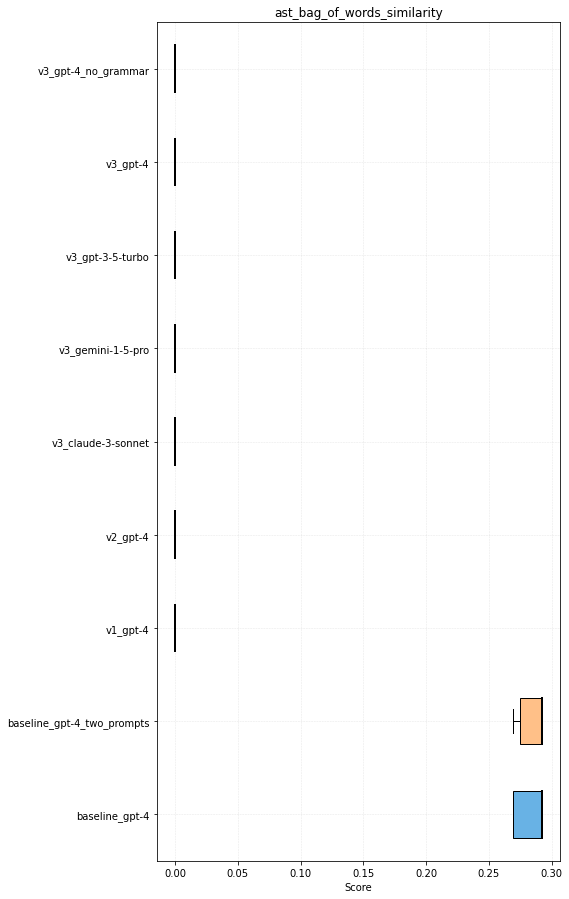

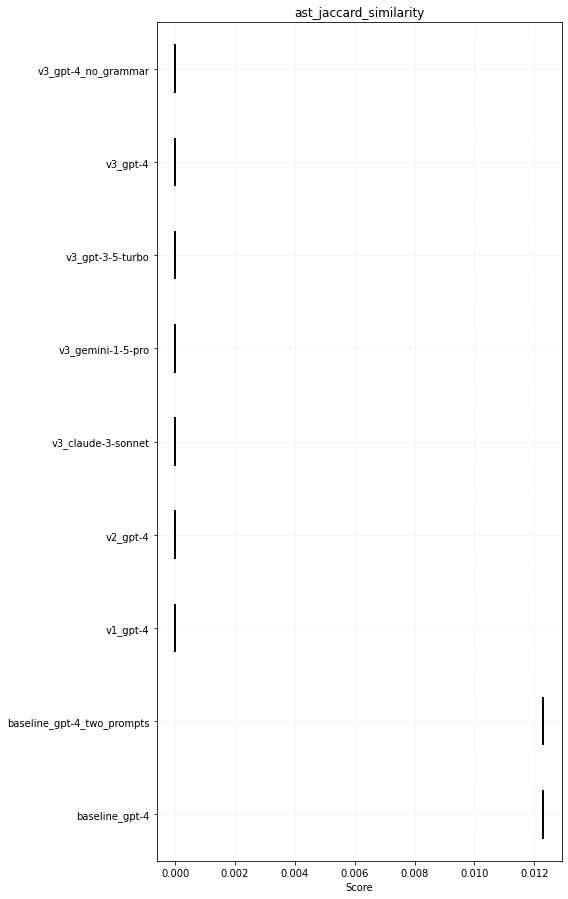

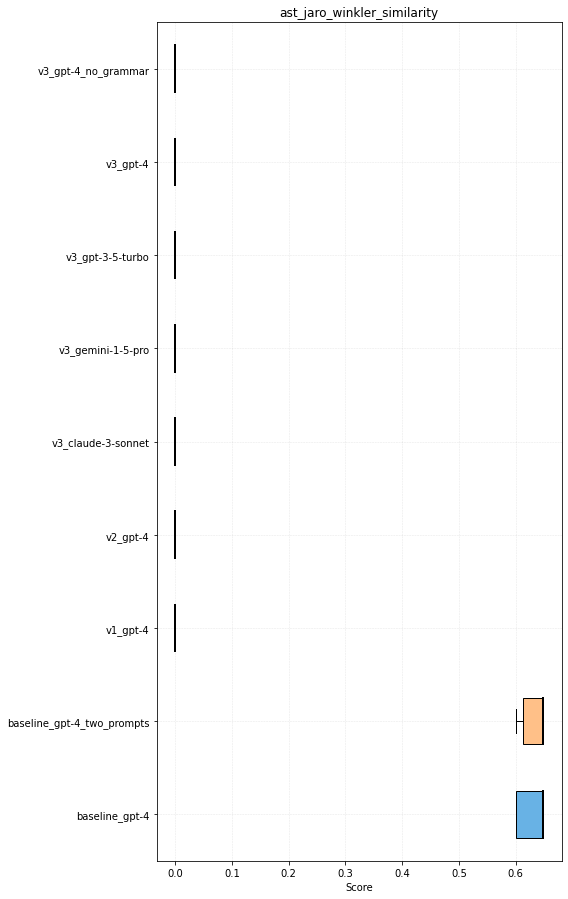

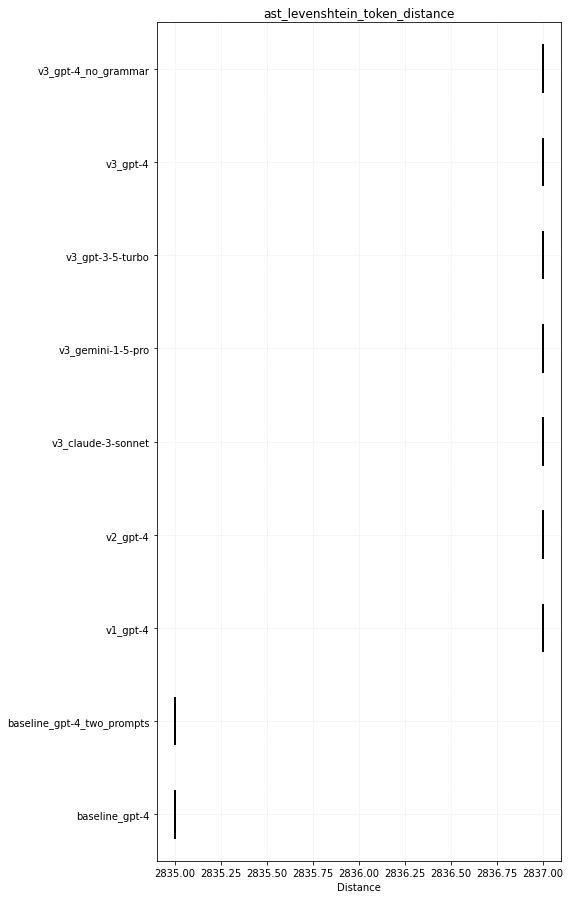

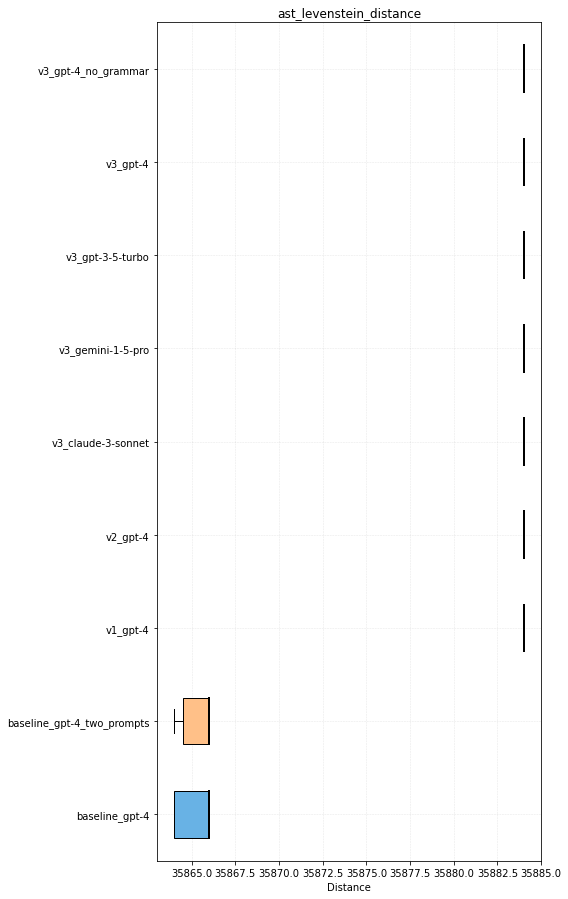

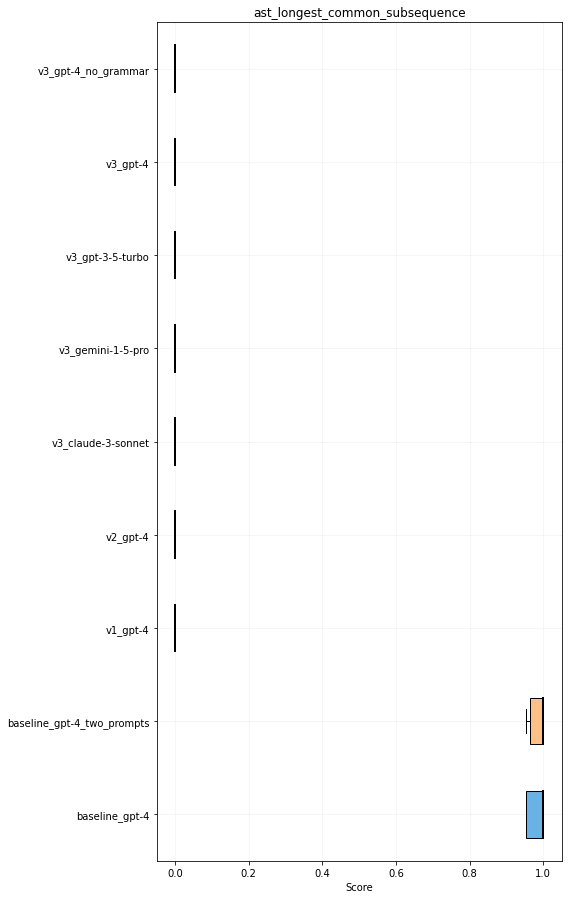

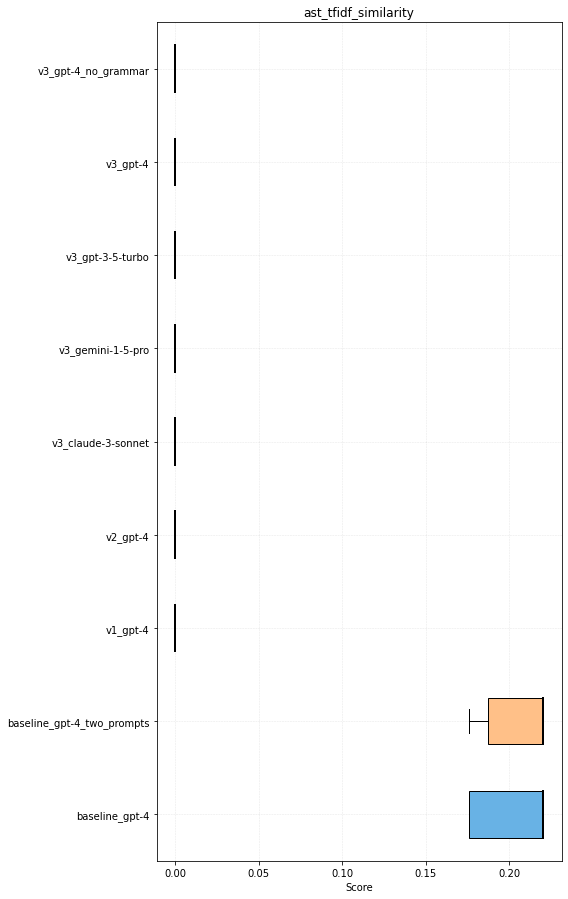

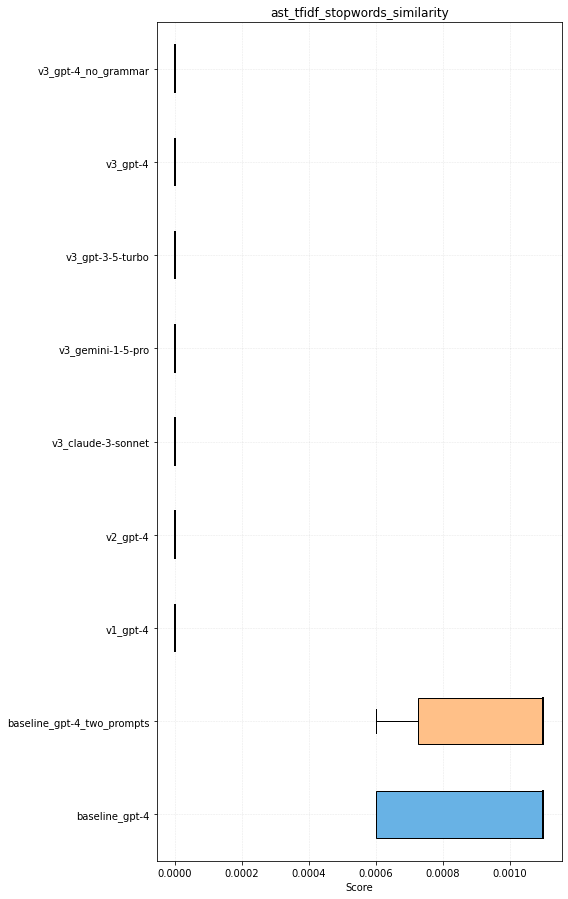

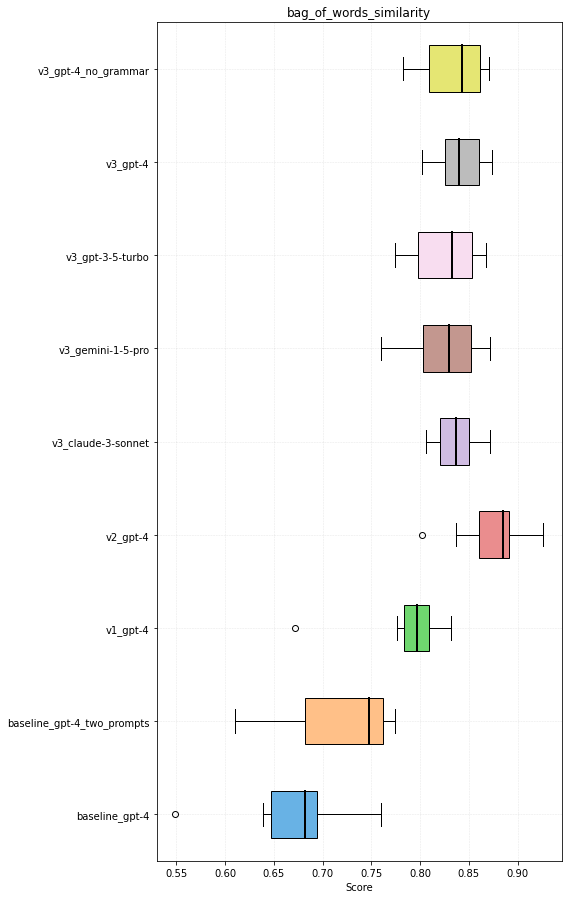

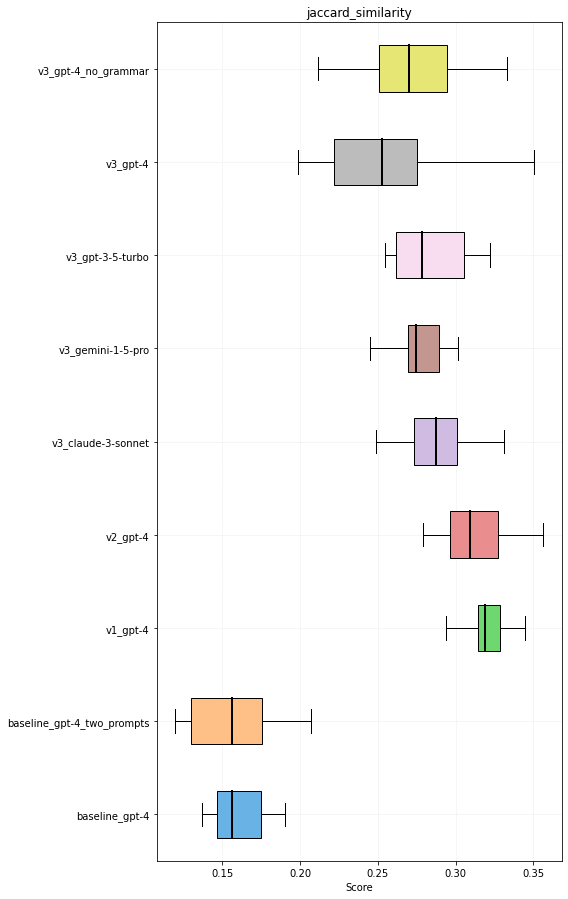

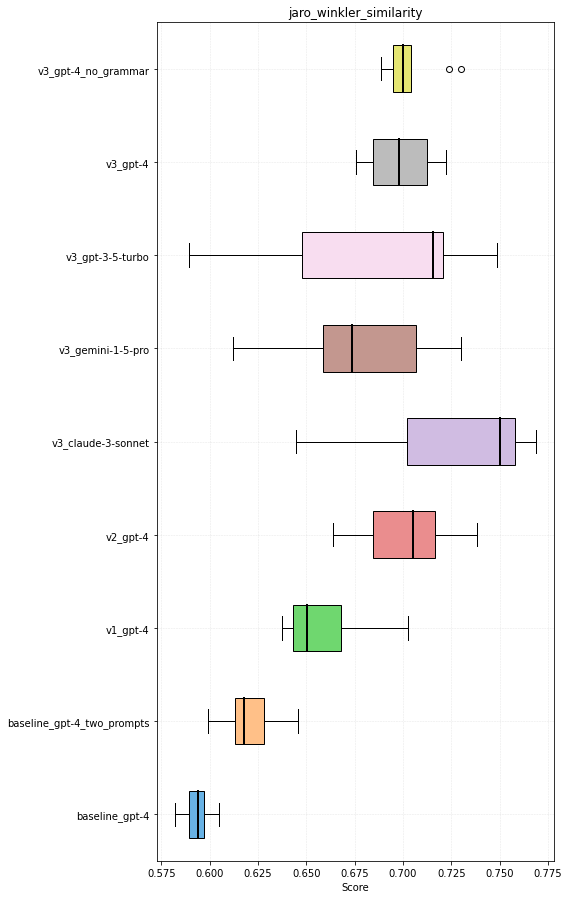

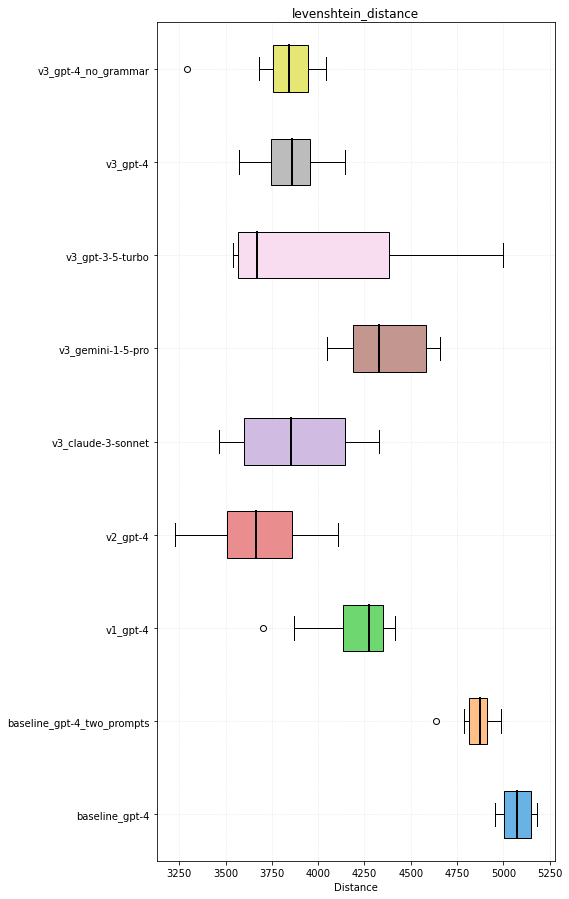

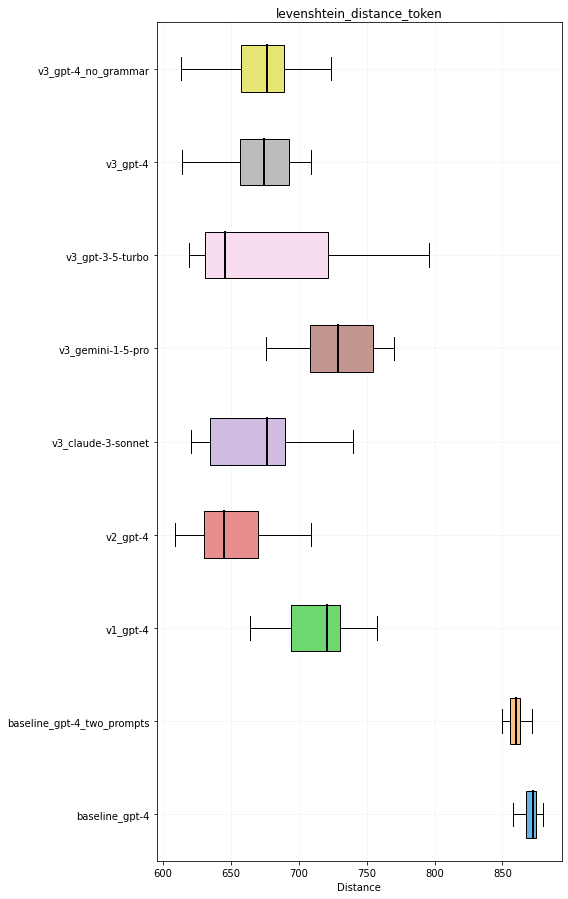

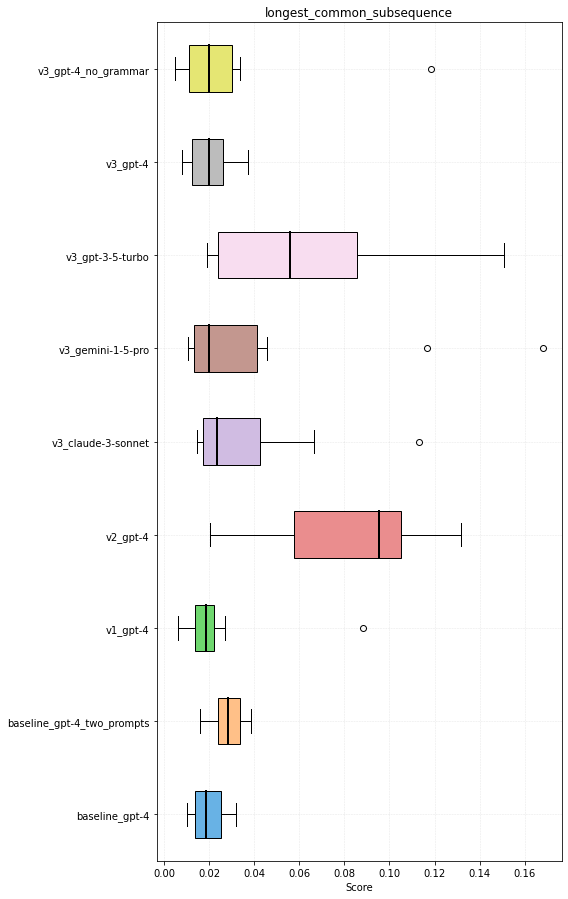

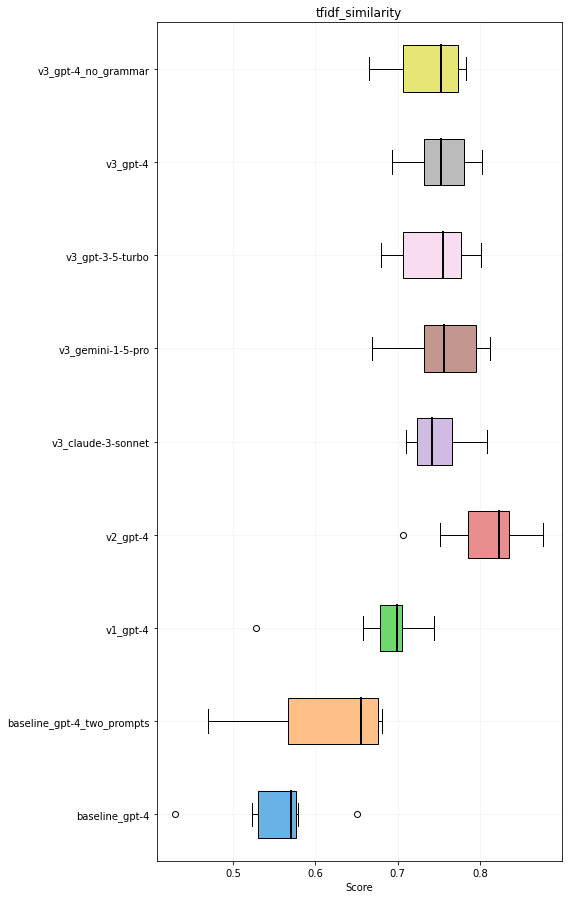

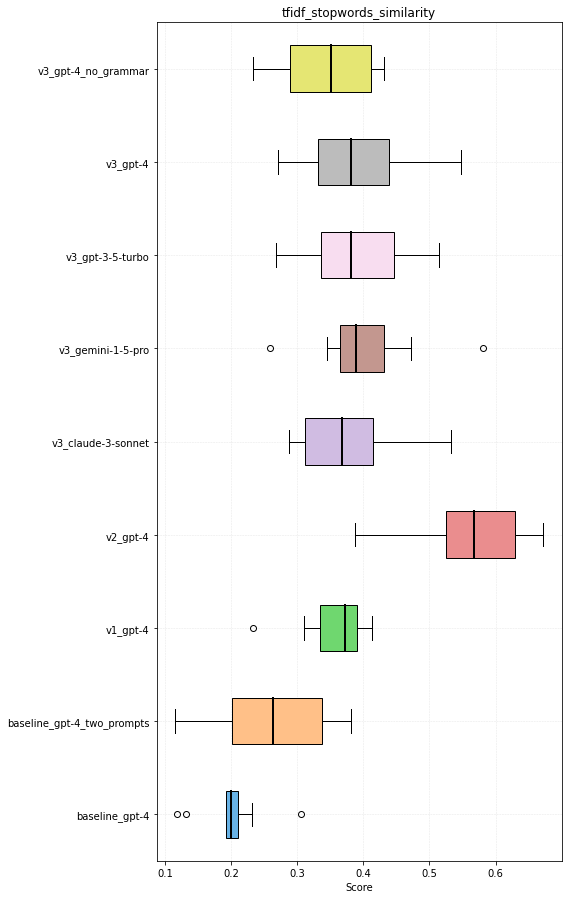

In [14]:
for i, sim_type in enumerate(similarity_types):
    boxplot_data = []
    version_labels = []

    for version, attempts in data.items():
        boxplot_data.append([attempts[attempt][sim_type] for attempt in attempts])
        version_labels.append(version)

    # Create a new figure for each similarity type
    fig, ax = plt.subplots(figsize=(8, 1.4*len(data.values())))
    bp = ax.boxplot(boxplot_data, labels=version_labels, vert=False, zorder=2, patch_artist=True)
    ax.set_title(sim_type)
    ax.set_xlabel('Score' if 'distance' not in sim_type.lower() else 'Distance')

    # Set the background color of the boxes to a light color
    for j, patch in enumerate(bp['boxes']):
        patch.set_facecolor(get_tinted_color(color_map(j), 8))

    for j, median in enumerate(bp['medians']):
        median.set(color='black', linewidth=2)


    ax.grid(color='black', linestyle='dashed', linewidth=0.5, alpha=0.1, zorder=1, )

    plt.tight_layout()
    plt.show()

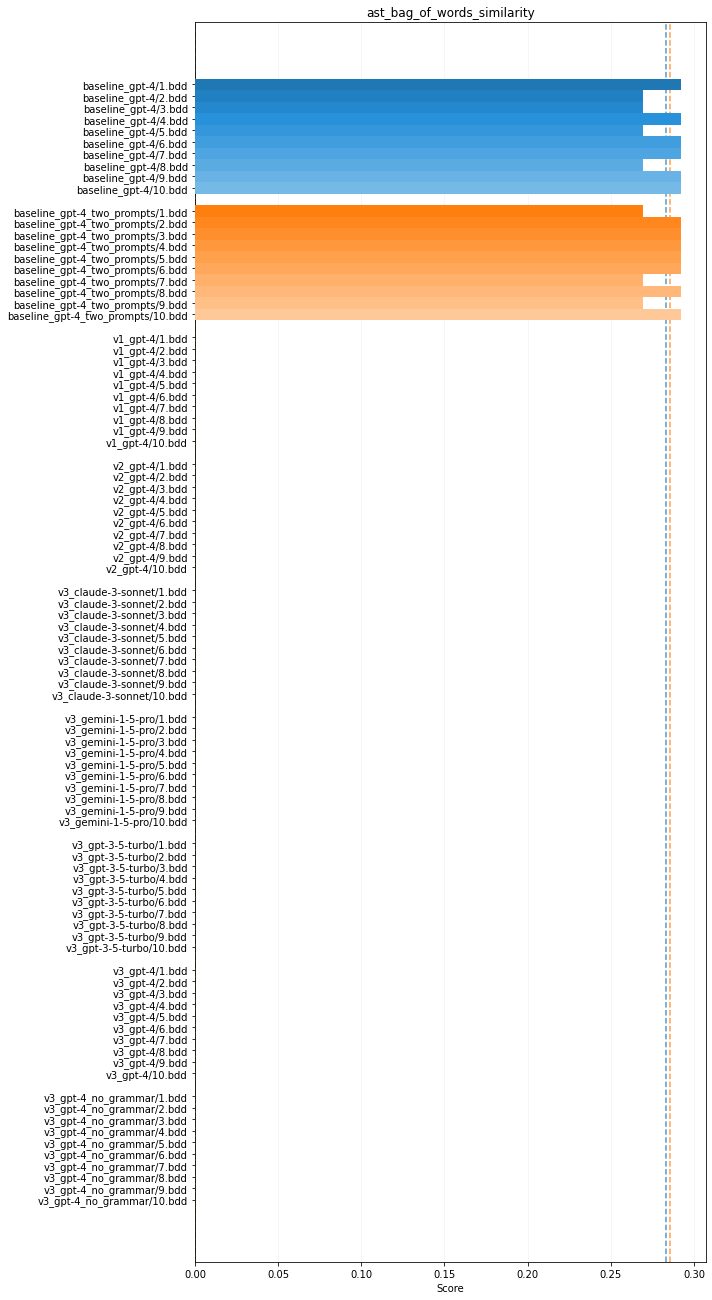

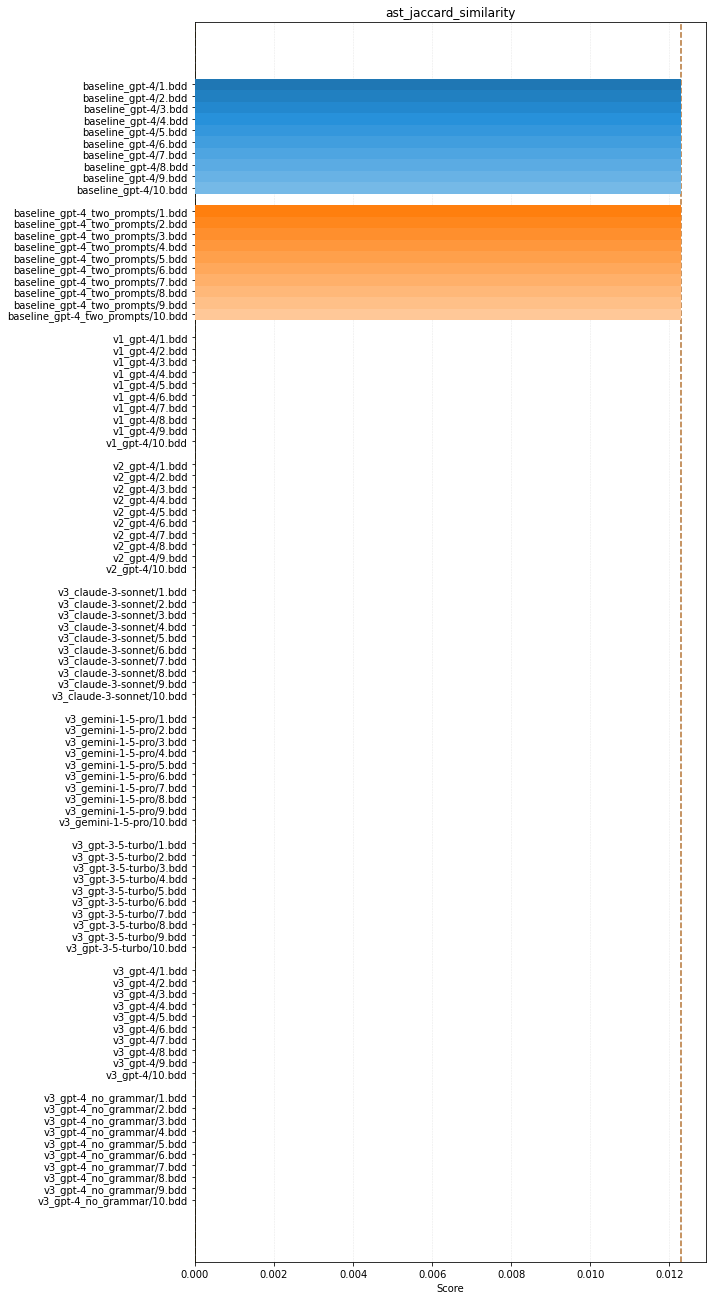

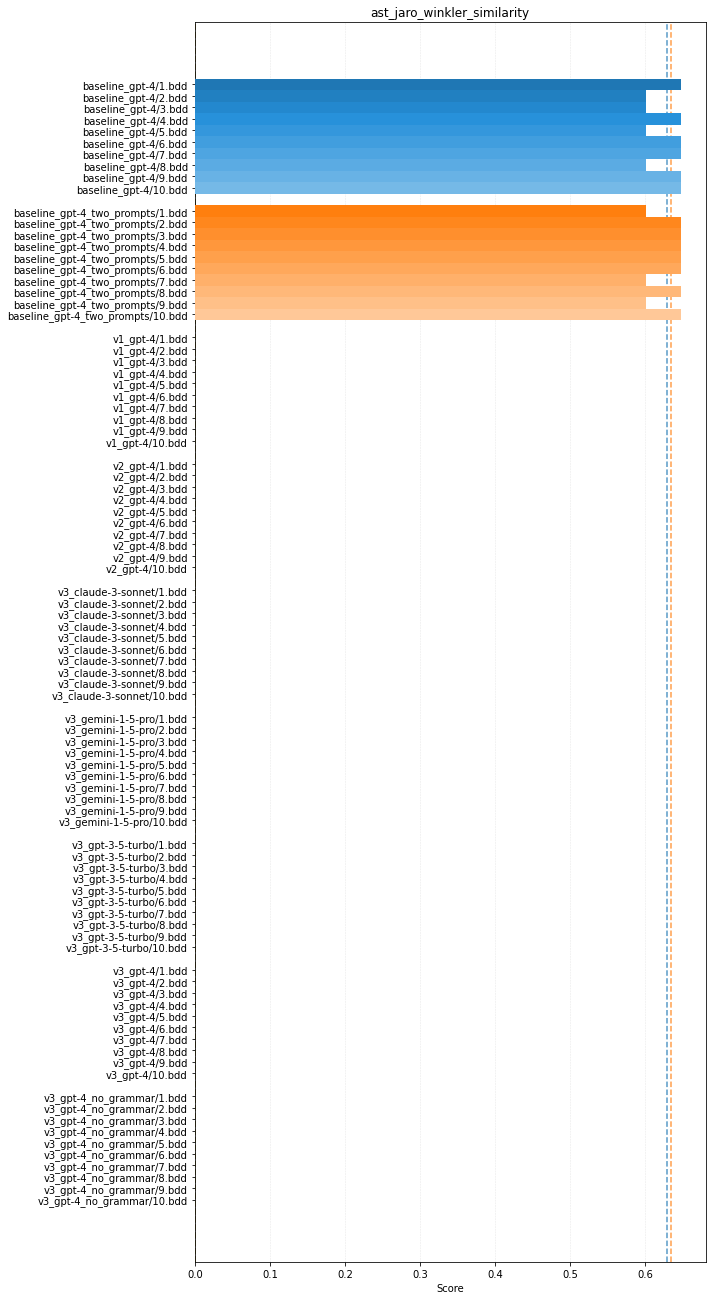

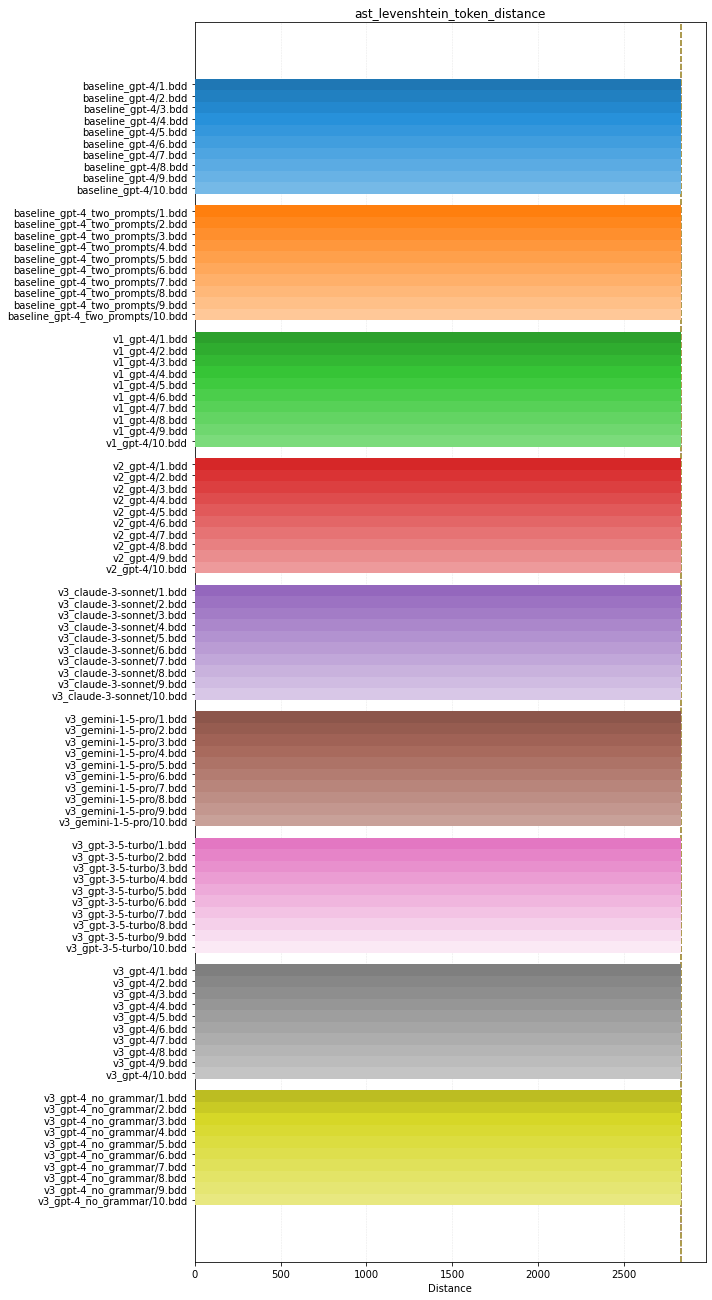

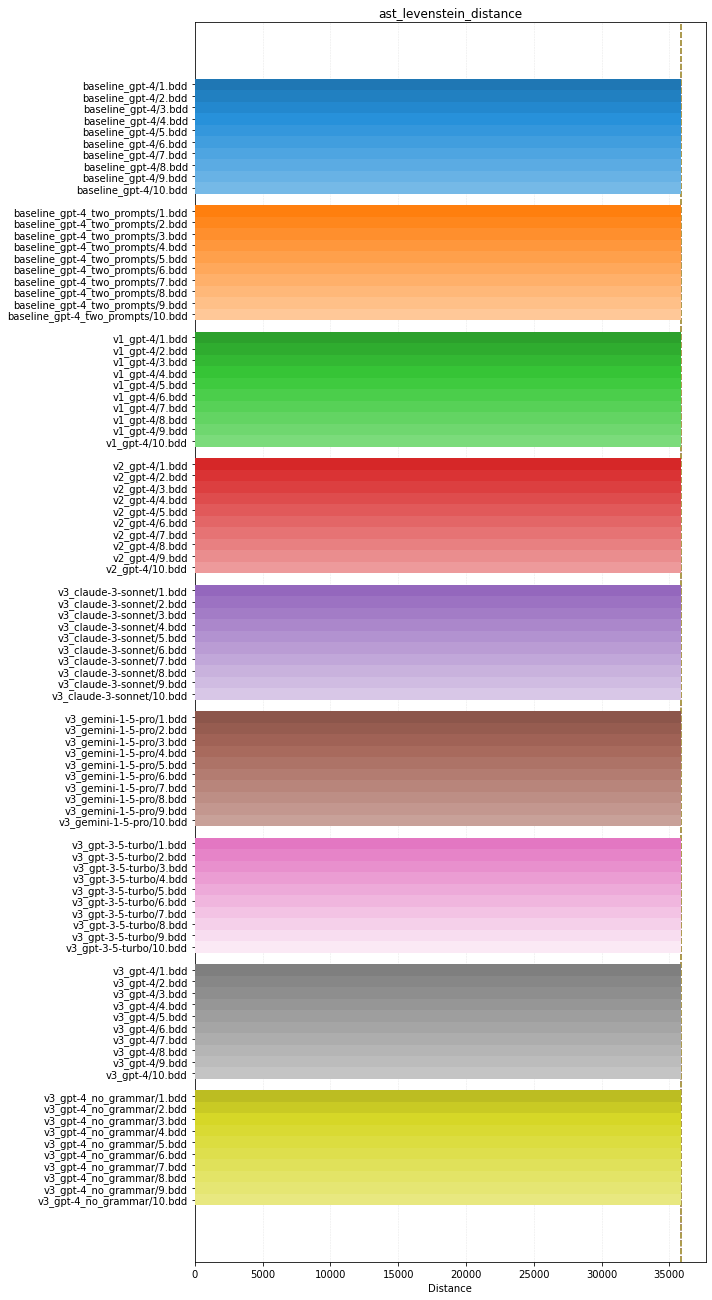

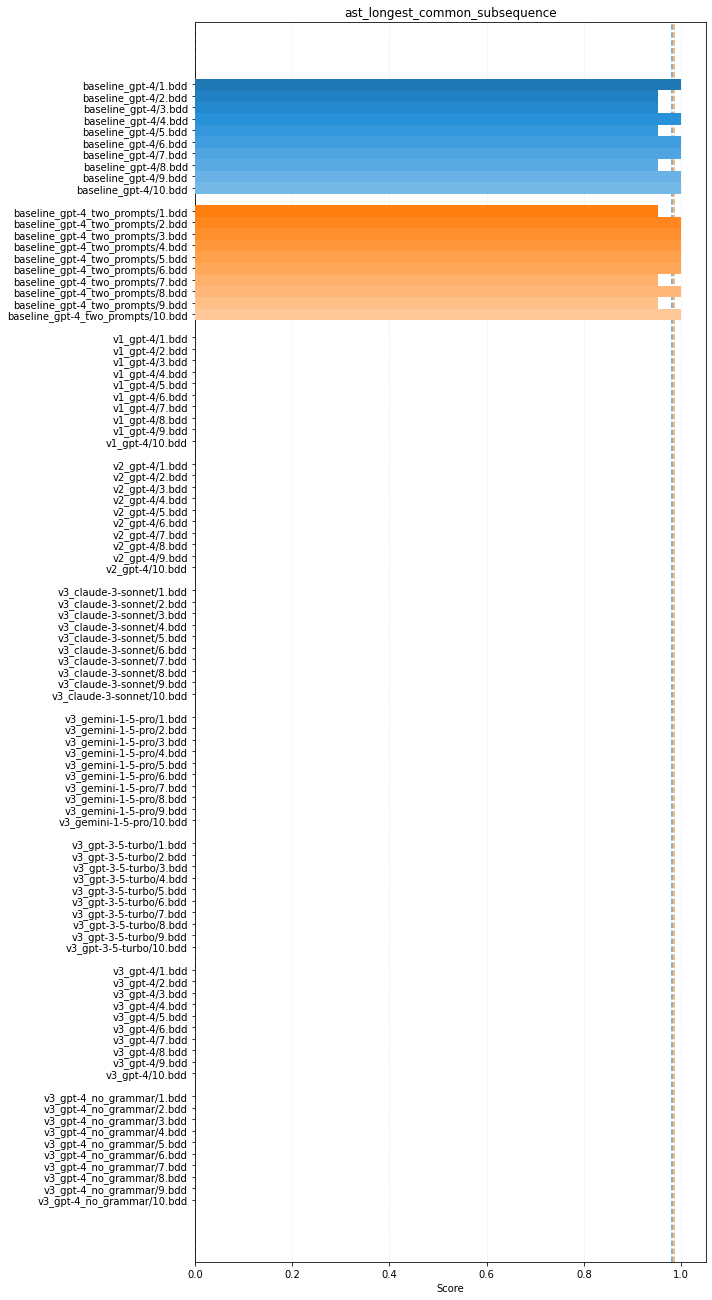

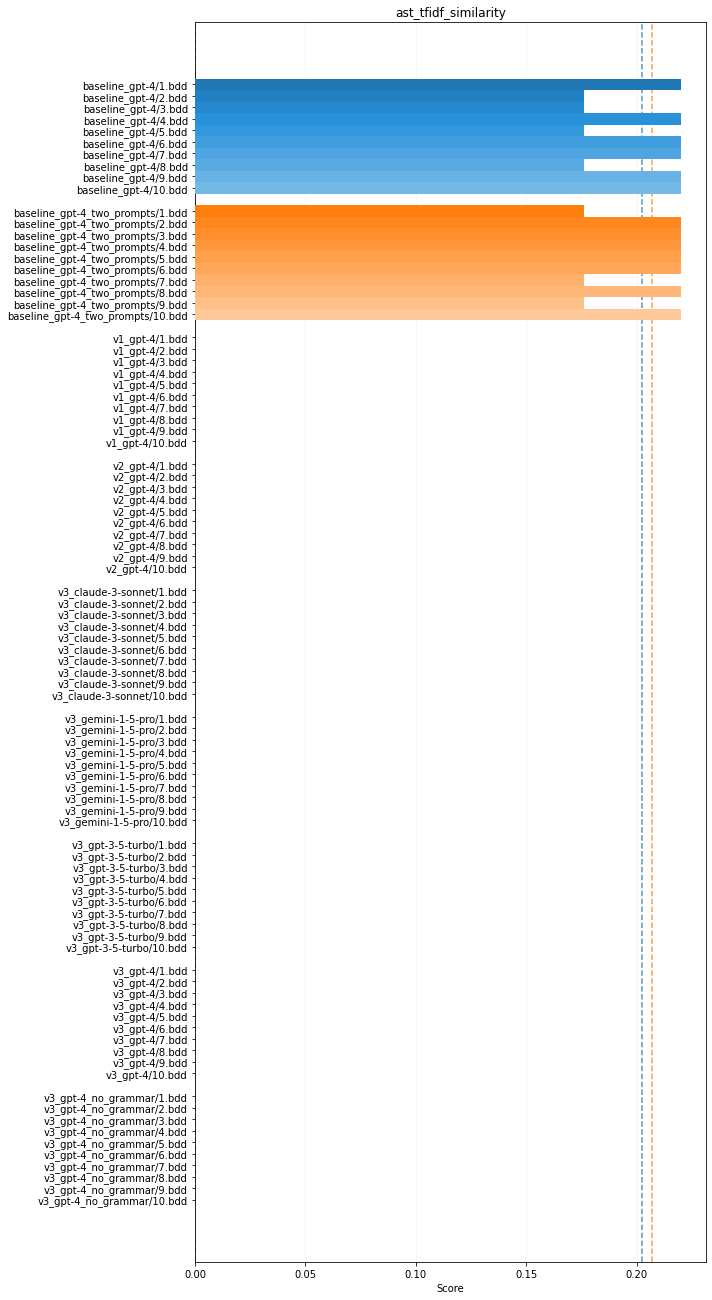

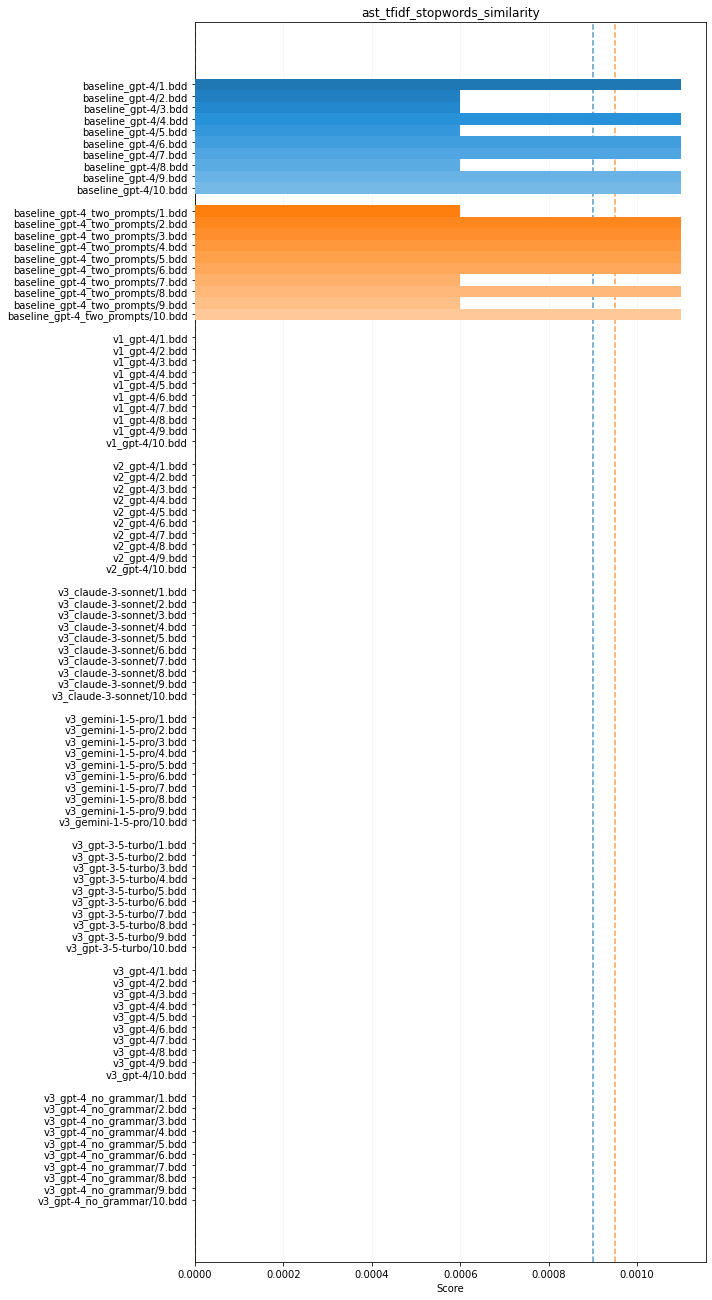

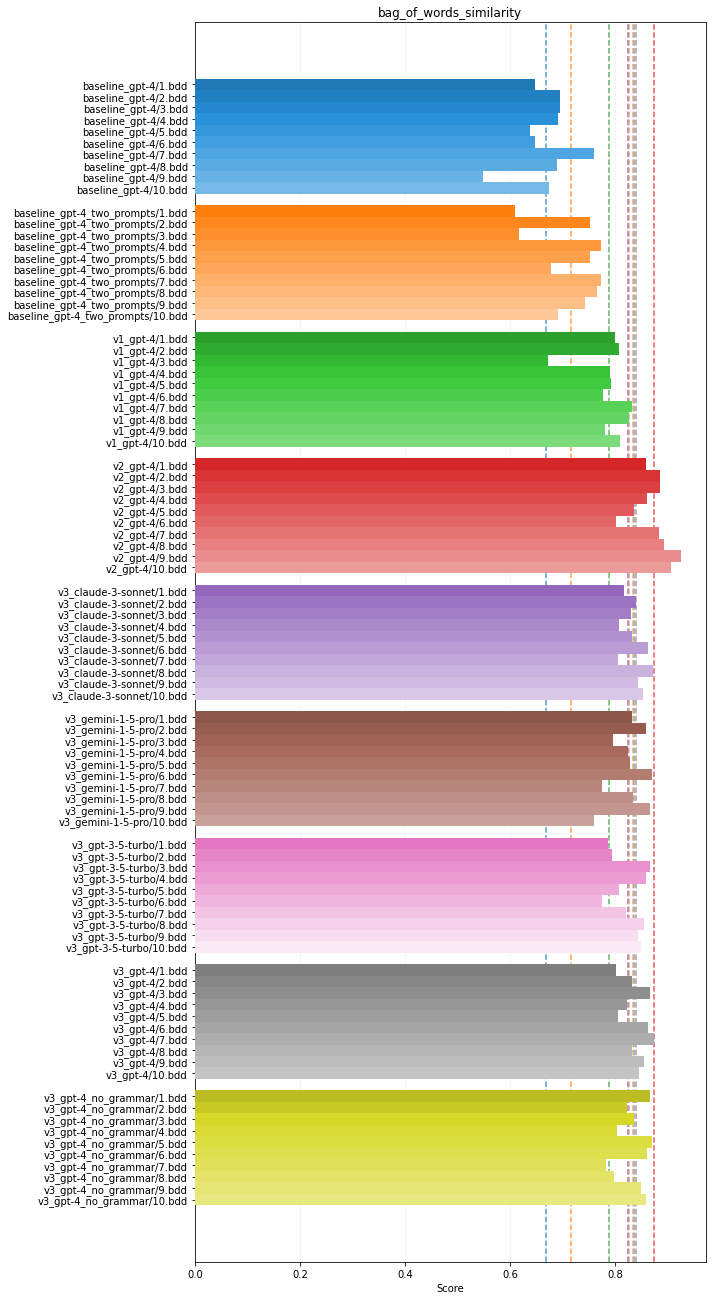

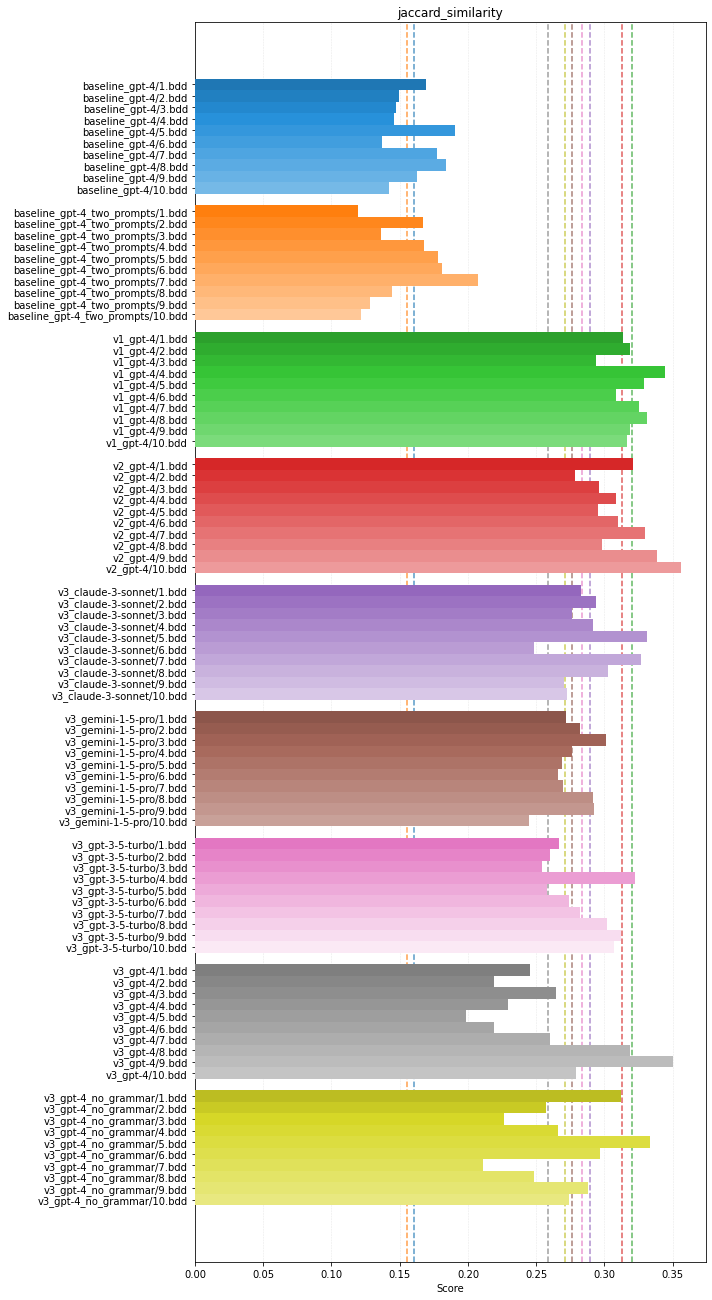

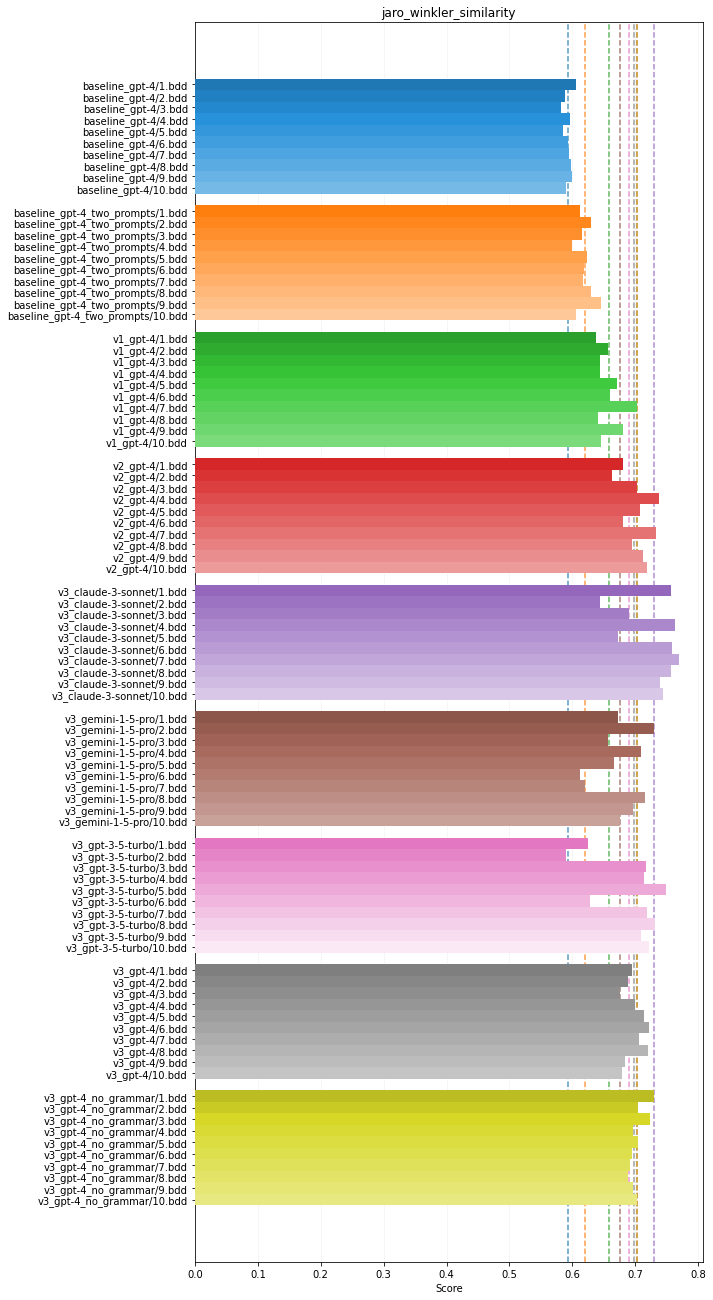

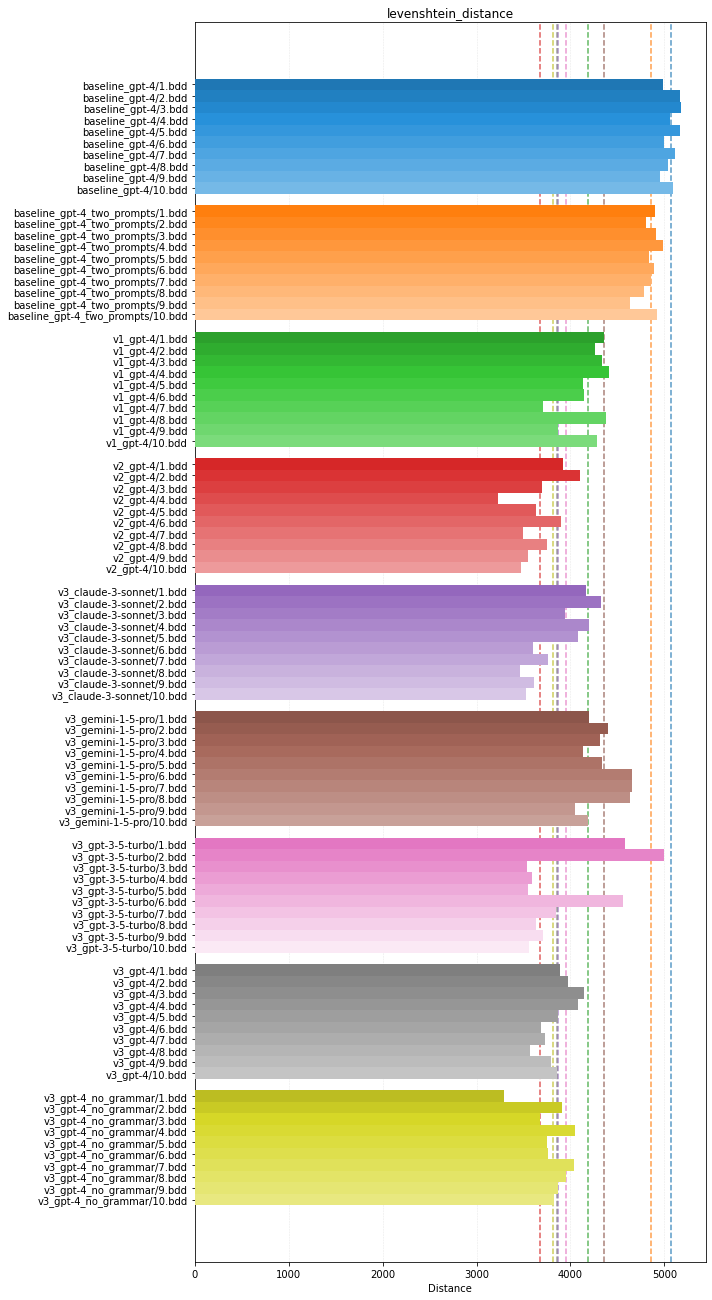

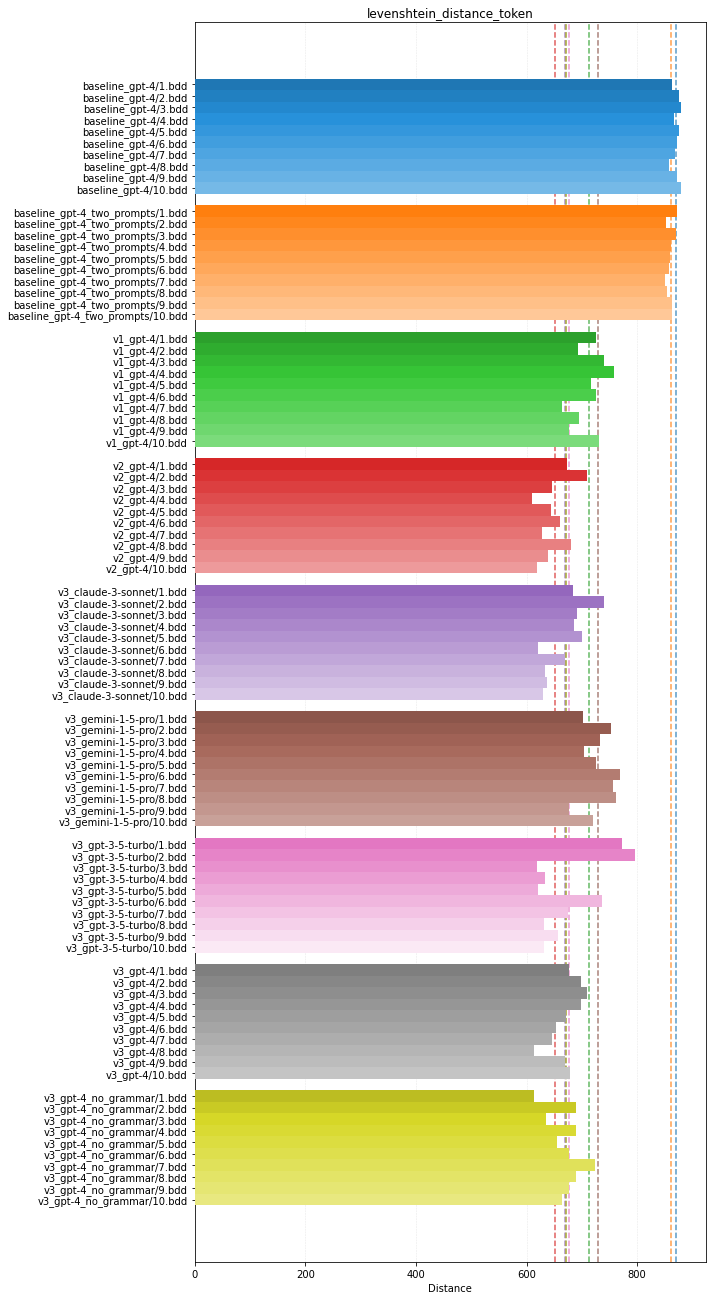

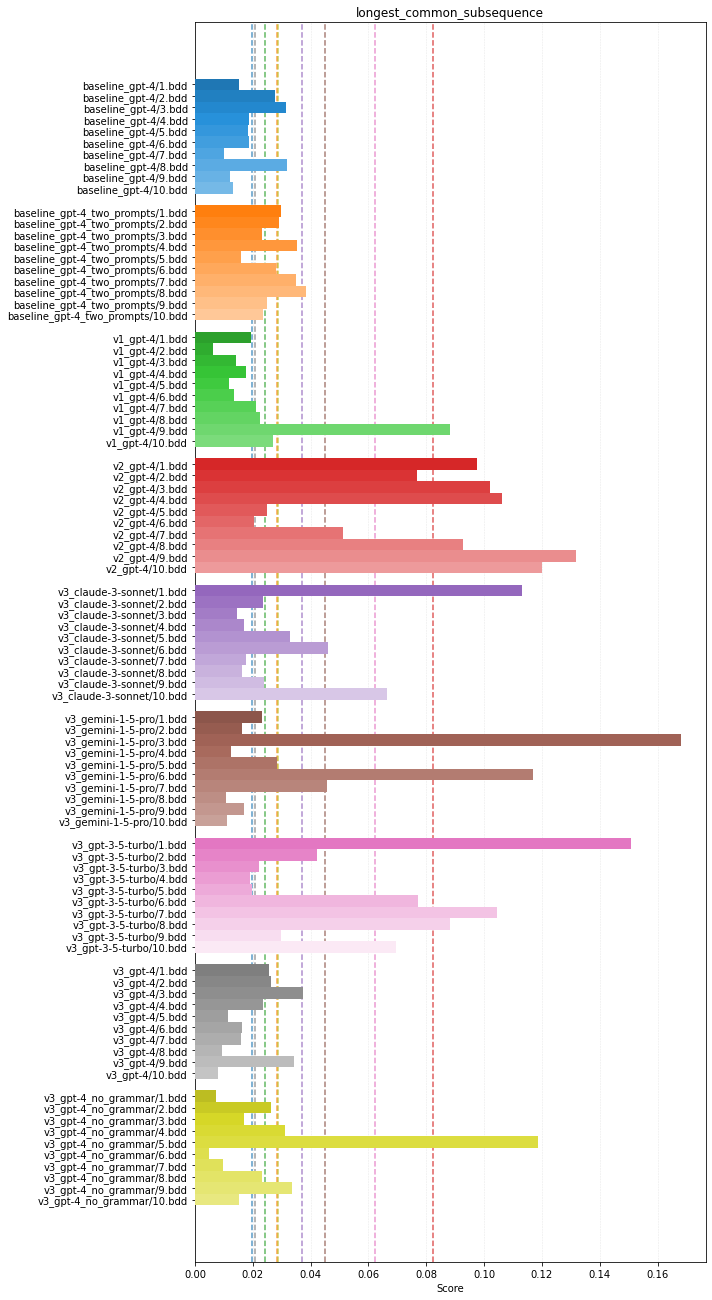

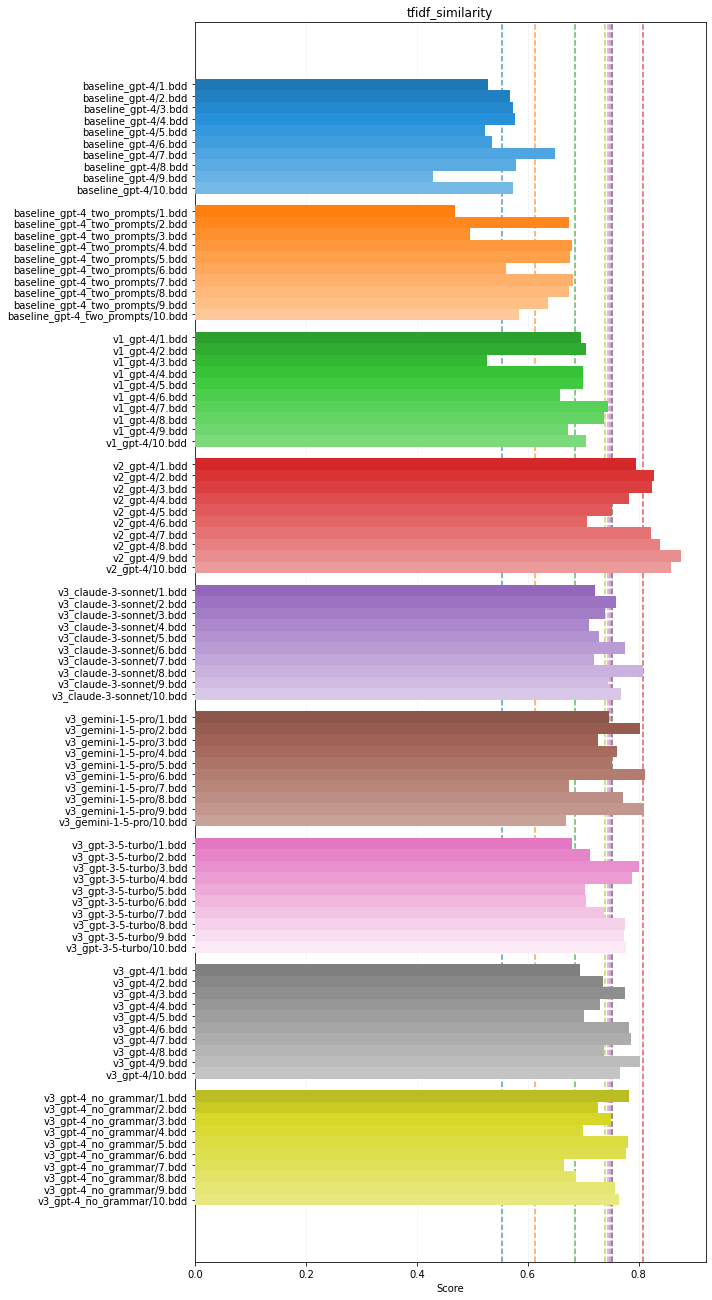

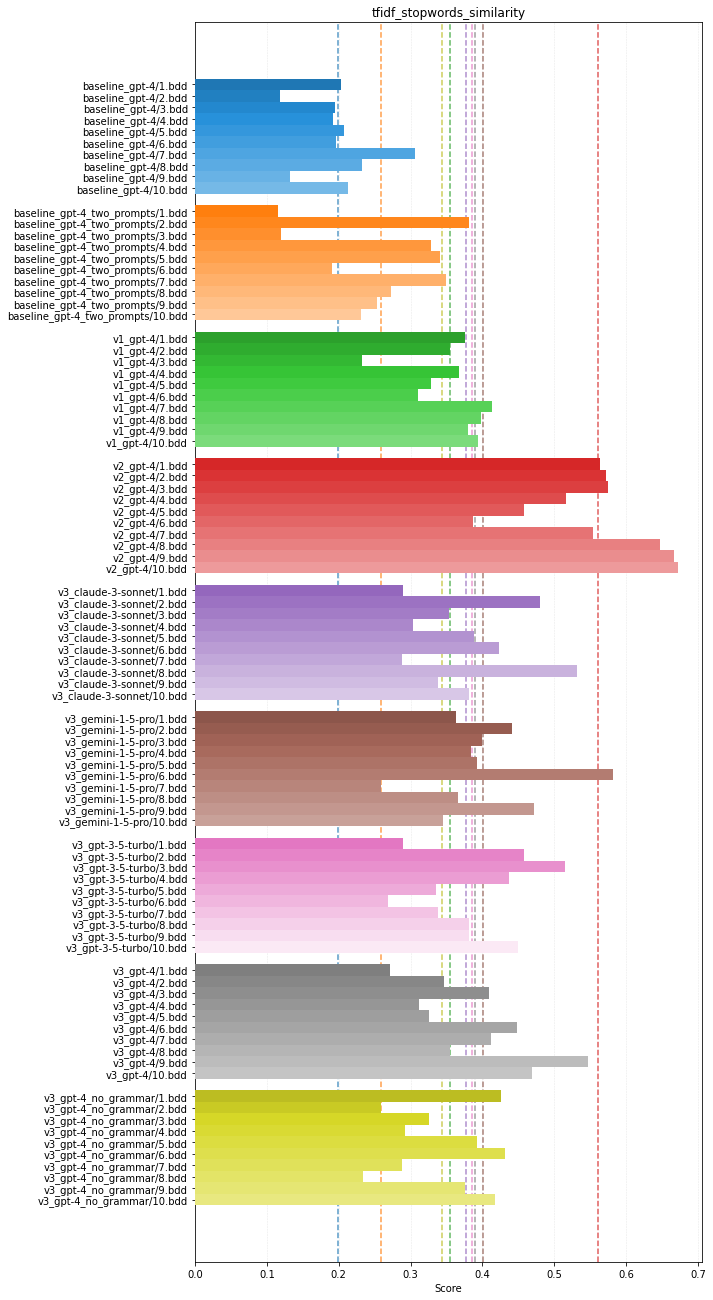

In [15]:
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages(get_filename_without_extension(file_path) + ".pdf")

bar_amount = 100 + len(data.items()) # 30
total_height = 1
bar_height = 1 / bar_amount

for i, sim_type in enumerate(similarity_types):
    fig, ax = plt.subplots(figsize=(10, bar_amount/6))

    # Initialize the position of the first bar
    current_bar_position = 0

    y_ticks = []
    y_tick_labels = []

    for j, (version, attempts) in enumerate(data.items()):

        scores_for_type = [attempts[attempt][sim_type] for attempt in attempts]
        color = color_map(j)

        # sort the attempts by the attempt number in the file name, this ensures that it goes 1,2,3... instead of 1,10,2...
        attempts = dict(sorted(attempts.items(), key=lambda x: int(x[0].split('.')[0])))

        for k, attempt in enumerate(attempts):
            # Create the bar with a higher zorder
            bar = ax.barh(
                current_bar_position - k * bar_height, 
                attempts[attempt][sim_type], 
                height=bar_height, 
                color=get_tinted_color(color_map(j), k), 
                label=f'{version}/{attempt}', 
                zorder=3)

            # Add the y position and label for this bar to the lists
            y_ticks.append(current_bar_position - k * bar_height)
            y_tick_labels.append(f'{version}/{attempt}')

        # Calculate the mean score for this file type
        mean_score = np.mean(scores_for_type)

        # Draw a vertical line at the mean score
        ax.axvline(mean_score, ymin=0, ymax=1, color=color, alpha= 0.75, linestyle='dashed', zorder=2, label=f'{version} Mean Score')

        # Update the position for the next file
        current_bar_position -= len(scores_for_type) * bar_height + bar_height # Add a small space between each file

    ax.set_title(sim_type)
    ax.set_xlabel('Score' if 'distance' not in sim_type.lower() else 'Distance')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels)

    # Add vertical lines at each x-tick with a lower zorder
    ax.grid(axis='x', color='black', linestyle='dashed', linewidth=0.5, alpha=0.1, zorder=1, )


    plt.tight_layout()
    plt.show()

    pdf.savefig(fig, bbox_inches='tight')

pdf.close()